# Optimizing diversified investment portfolios considering cryptocurrencies and other Brazilian financial products, using Markowitz model approach, GARCH models and Genetic algorithms.

*** By Pablo Calvache***

In [1]:
#Imports

from bs4 import BeautifulSoup
from io import StringIO
import pandas as pd
import certifi
import urllib3
import pycurl
import datetime, time

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random
import warnings

%matplotlib inline

# Data extraction

Using Python curl and HTML libraries, data from websites containing closing prices of either stocks and cryptocurrencies assets, is extracted and summarized. Such data is public!

** OBS: ** Regardless the Brazilian stocks prices are given in *BRL (Real)* and the crypto prices are given in *USD (American Dolar)*,  transforming from USD to BRL is desnecessary due only differentiated series are considered by Markowitz models. 

## Stock info

Data at this stage, is obtained from Yahoo finance portal because of its HTML structure and easiness at reading.  

In [2]:
# https://br.financas.yahoo.com/quote/PETR4.SA/history?period1=1452045600&period2=1515549600&interval=1d&filter=history&frequency=1d
def date_to_seconds(date_string, formatting = '%d-%m-%Y' ):
    t = datetime.datetime.strptime(date_string, formatting)
    return int(time.mktime(t.timetuple()))

def get_historical_data(name, init, end):
    data_close_prices, index_date = [], []
    url = "https://br.finance.yahoo.com/quote/"+name+"/history?period1="+str(init)+"&period2="+str(end)+"&interval=1d&filter=history&frequency=1d"
    print('Downloading from ... '+ url)
    http = urllib3.PoolManager(cert_reqs='CERT_REQUIRED', ca_certs=certifi.where())
    r = http.request('GET', url)
    rows = BeautifulSoup(r.data, 'html.parser').findAll('table')[1].tbody.findAll('tr')
    
    for each_row in rows:
        divs = each_row.findAll('td')
        #data.append({'date': divs[0].text, 
                    #'open': divs[1].text,
                    #'max': divs[2].text,
                    #'min': divs[3].text,
                    #'close': divs[4].text})
                    
        if len(divs) < 4:
            continue
            
        data_close_prices.append(float(divs[4].text.replace(",", ".")))
        index_date.append(divs[0].text)
    
    key = 'stock_close_'+name.split('.')[0]
    return pd.DataFrame({key:list(reversed(data_close_prices))}, index = list(reversed(index_date)))

def download_portafolio_as_pandas(papers, interval):
    portafolio_pd = pd.DataFrame()
    for paper in papers:
        init_sec = date_to_seconds(interval['init'])
        end_sec = date_to_seconds(interval['end'])
        if portafolio_pd.size == 0:
            portafolio_pd = get_historical_data(paper, init_sec, end_sec)
        else:
            portafolio_pd = portafolio_pd.join(get_historical_data(paper, init_sec, end_sec), how ='left')
    
    return portafolio_pd

In [3]:
# downloading data

papers = ["ABEV3.SA", "ITUB4.SA", "BBDC3.SA", "PETR4.SA", "VALE3.SA", "BSAN33.SA", "ITSA4.SA", 
          "VIVT4.SA", "BBSE3.SA", "CIEL3.SA"]

#"BRSR6.SA","ELET6.SA","CESP6.SA","PCAR4.SA",
#          "CGAS5.SA","CMIG4.SA","CPLE6.SA","ELPL4.SA",

# Yahoo allows to download 100 days only, therefore
time_intervals = [{'init' : '01-06-2018', 'end' : '20-06-2018'},
                  {'init' : '06-03-2018', 'end' : '30-05-2018'},
                  {'init' : '01-09-2017', 'end' : '05-03-2018'},
                  {'init' : '13-04-2017', 'end' : '31-08-2017'},
                  {'init' : '01-01-2017', 'end' : '12-04-2017'}]

stock_prices_pd = pd.DataFrame()
for time_interval in time_intervals:
    if stock_prices_pd.size == 0:
        stock_prices_pd = download_portafolio_as_pandas(papers, time_interval)
    else:
        stock_prices_pd = pd.concat([download_portafolio_as_pandas(papers, time_interval), stock_prices_pd])

#### Formatting Date index

In [4]:
def formating_yahoo_date(date_text):
    date_text = date_text.replace(' de ', '-')
    splitted_date = date_text.split('-')
    day, month_pt, year = splitted_date[0], splitted_date[1], splitted_date[2]
    return {
      'dez': lambda year, day: year + '-' + '12' + '-' + day,
      'nov': lambda year, day: year + '-' + '11' + '-' + day,
      'out': lambda year, day: year + '-' + '10' + '-' + day,
      'set': lambda year, day: year + '-' + '09' + '-' + day,
      'ago': lambda year, day: year + '-' + '08' + '-' + day,
      'jul': lambda year, day: year + '-' + '07' + '-' + day,
      'jun': lambda year, day: year + '-' + '06' + '-' + day,
      'mai': lambda year, day: year + '-' + '05' + '-' + day,
      'abr': lambda year, day: year + '-' + '04' + '-' + day,
      'mar': lambda year, day: year + '-' + '03' + '-' + day,
      'fev': lambda year, day: year + '-' + '02' + '-' + day,
      'jan': lambda year, day: year + '-' + '01' + '-' + day
    }[month_pt](year, day)

stock_prices_pd.index = [formating_yahoo_date(date_yahoo) for date_yahoo in stock_prices_pd.index.values]

## Croptocurrencies

#### Loading Objects from coinMarket

Due criptocurrencies are harder to trade and exchange, an important criterion in ordet to select the correct ones is the ease in exhancging... 

In [6]:
#date format = 20170817
def formating_coinmarket_date(date_text):
    date_text = date_text.replace(',', '')
    splitted_date = date_text.split(' ')
    day, month_pt, year = splitted_date[1], splitted_date[0], splitted_date[2]
    return {
      'Dec': lambda year, day: year + '-' + '12' + '-' + day,
      'Nov': lambda year, day: year + '-' + '11' + '-' + day,
      'Oct': lambda year, day: year + '-' + '10' + '-' + day,
      'Sep': lambda year, day: year + '-' + '09' + '-' + day,
      'Aug': lambda year, day: year + '-' + '08' + '-' + day,
      'Jul': lambda year, day: year + '-' + '07' + '-' + day,
      'Jun': lambda year, day: year + '-' + '06' + '-' + day,
      'May': lambda year, day: year + '-' + '05' + '-' + day,
      'Apr': lambda year, day: year + '-' + '04' + '-' + day,
      'Mar': lambda year, day: year + '-' + '03' + '-' + day,
      'Feb': lambda year, day: year + '-' + '02' + '-' + day,
      'Jan': lambda year, day: year + '-' + '01' + '-' + day
    }[month_pt](year, day)

def get_values_table(source_path, currency, start_date, end_date):
    url = source_path.format(currency = currency, start_date = start_date, end_date = end_date)
    http = urllib3.PoolManager(cert_reqs='CERT_REQUIRED', ca_certs=certifi.where())
    print('Downloading from ... '+ url)
    r = http.request('GET', url)
    #r = urllib.urlopen(url).read() # Python 2
    soup = BeautifulSoup(r.data, 'html.parser')
    table = soup.find('table')
    data = []
    table_body = table.find('tbody')

    rows = table_body.find_all('tr')
    for row in rows:
        cols = row.find_all('td')
        cols = [ele.text.strip() for ele in cols]
        data.append([ele for ele in cols if ele]) # Get rid of empty values
    
    df_temp = pd.DataFrame.from_records(list(reversed(data)))
    df_temp.columns = ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Market Cap']
   
    close_prices = [float(close) for close in list(df_temp['Close'])]
    df_close = pd.DataFrame({'ccurr_'+currency+'_close' : close_prices}, index = df_temp['Date'])
    
    return df_close

def download_cripto_currencies_close_price_as_pandas(currencies, date_interval):
    source_path = 'https://coinmarketcap.com/currencies/{currency}/historical-data/?start={start_date}&end={end_date}'
    ccurrencies_pd = pd.DataFrame()
    for key, val in currencies.items():
        if ccurrencies_pd.size == 0:
            ccurrencies_pd = get_values_table(source_path, currencies[key], 
                       date_interval['init'].replace('-',''), 
                       date_interval['end'].replace('-',''))
        else:
            temp_pd = get_values_table(source_path, currencies[key], 
                       date_interval['init'].replace('-',''), 
                       date_interval['end'].replace('-',''))
            ccurrencies_pd = ccurrencies_pd.join(temp_pd, how ='left')
    
    return ccurrencies_pd

def from_usd_to_pt(currencies_pd, exchange_pd):
    currencies_pd_temp = currencies_pd.join(exchange_pd, how='inner')
    return cripto_currencies_pd.transform(lambda x: x * currencies_pd_temp['close_price_usd_pt'])

In [7]:
currencies = {'bitcoin' : 'bitcoin', 
              'ethereum' : 'ethereum', 
              'bitcoin_cash' : 'bitcoin-cash', 
              'litecoin' : 'litecoin',
              'ripple' : 'ripple',
              'Cardano' : 'cardano',
              'NEO' : 'neo',
              'stellar': 'stellar',
              'monero' : 'monero',
              'EOS' : 'eos',
              'IOTA' : 'iota',
              'EOS' : 'eos',
              'tether' : 'tether',
              'TRON' : 'tron',
              'dash' : 'dash'}

date_interval = {'init': '2017-01-01', 'end' : '2018-06-20' }

cripto_currencies_pd = download_cripto_currencies_close_price_as_pandas(currencies, date_interval)
cripto_currencies_pd.index =[formating_coinmarket_date(date_coinm) for date_coinm in cripto_currencies_pd.index.values]
#cripto_currencies_pd = from_usd_to_pt(cripto_currencies_pd, usd_br_pd)

In [8]:
# trabajar con coingecko - op 1
# 
cripto_currencies_pd.head()

,ccurr_bitcoin_close,ccurr_ethereum_close,ccurr_bitcoin-cash_close,ccurr_litecoin_close,ccurr_ripple_close,ccurr_cardano_close,ccurr_neo_close,ccurr_stellar_close,ccurr_monero_close,ccurr_eos_close,ccurr_iota_close,ccurr_tether_close,ccurr_tron_close,ccurr_dash_close
2017-01-01,998.33,8.17,NaN,4.51,0.006368,NaN,0.141841,0.002481,13.97,NaN,NaN,1.0,NaN,11.23
2017-01-02,1021.75,8.38,NaN,4.65,0.006311,NaN,0.145642,0.002477,16.05,NaN,NaN,1.0,NaN,11.81
2017-01-03,1043.84,9.73,NaN,4.63,0.006386,NaN,0.140422,0.002554,16.09,NaN,NaN,1.0,NaN,12.78
2017-01-04,1154.73,11.25,NaN,4.84,0.006570,NaN,0.136734,0.002735,18.53,NaN,NaN,1.0,NaN,16.52
2017-01-05,1013.38,10.25,NaN,4.29,0.006201,NaN,0.131070,0.002598,16.19,NaN,NaN,1.0,NaN,14.38


## Merging Data and making series stationary

In order to avoid biases caused by sporious correlations and not stationary trends a and variance, the original 'closing price' series of each asset, a derivation and logaritmic scale transformation is performed in order to make the series stationary in trend and variance. Such method delivers the data in a format compatible with the Markowitz model input, and such transformations also are kind of standar in finance analyisis.

According to P. Morettin, the relative variance or the *simple liquidity return* $R_t$ of an asset is given by:

$$Rt = \frac{P_t - P_{t-1}}{P_{t-1}}$$


As $R_t$ is defined as the expected return of an asset, generally expressed as a percent value, $r_t$ however is defined as the *return rate* of an asset, given by:

$$r_t = ln(\frac{P_t}{P_{t-1}})$$

Therefore, a simple return $R_t$ is obtained by: 

$$ R_t = {e^{r_t}} - 1 $$


The first term presented above $R_t$, is pretended to be used when the optimization takes place, while $r_t$ is the termo to be predicted with a GARCH model.

In [10]:
def get_returns_in_percent(pd_dataframee):
    return (pd_dataframee.diff() / pd_dataframee.shift(periods=1))*100

def get_rate_return(pd_dataframee):
    pd_temp = np.log(pd_dataframee)
    return ((pd_temp.diff()))

** Non stationary Time Series **

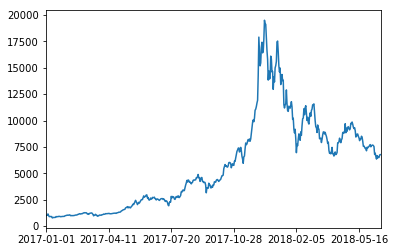

In [560]:
cripto_currencies_pd['ccurr_bitcoin_close'].plot()

** *Diff* or First order Derived Series: Making the series stationary in trend**

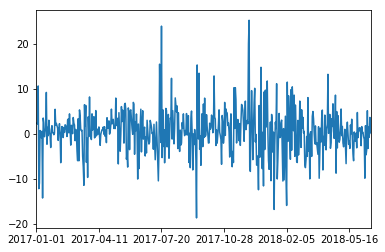

In [13]:
get_returns_in_percent(cripto_currencies_pd)['ccurr_bitcoin_close'].plot()

**Most of the time series models works with $r_t$ (spin term??) rather than $R_t$. So by applying the $r_t$ function defined above, we obtain:**

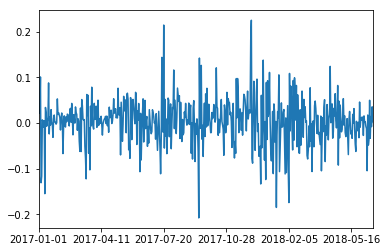

In [14]:
get_rate_return(cripto_currencies_pd)['ccurr_bitcoin_close'].plot()

** Checking the time series distribution, we get a normal distribution **

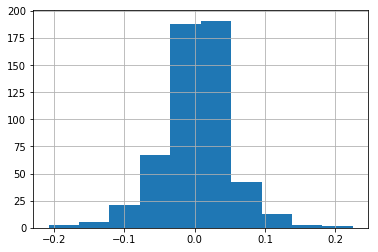

In [16]:
get_rate_return(cripto_currencies_pd)['ccurr_bitcoin_close'].hist()

### Merging Data and filling NaN values

NaN values are in the dataframe due several assets (some cryptocurrencies mainly) have not got a long track closing price history. Such as the case with Cardano and Bit Coin Cash, the first one mentioned for instance has history starting from 13-10-2017 only, hence it is assumed there was not any variance in closing prices difference percent (already differentiated series) before that point filling such missing values with 0. This applies also for None values along the data.

In [19]:
# Stocks percent returns
percent_stocks_returns = get_rate_return(stock_prices_pd)
percent_stocks_returns = percent_stocks_returns.fillna(0)

# Criptocurrencies percent returns
percent_cripto_returns = get_rate_return(cripto_currencies_pd)
percent_cripto_returns = percent_cripto_returns.fillna(0)

# Merged DF
portafolio_pd = stock_prices_pd.join(cripto_currencies_pd, how = 'inner')
#portafolio_pd = portafolio_pd.join(fixed_rent_pd, how = 'inner')
percent_returns_pd = get_rate_return(portafolio_pd)
percent_returns_pd = percent_returns_pd.fillna(0)

percent_returns_pd.head()

,stock_close_ABEV3,stock_close_ITUB4,stock_close_BBDC3,stock_close_PETR4,stock_close_VALE3,stock_close_BSAN33,stock_close_ITSA4,stock_close_VIVT4,stock_close_BBSE3,stock_close_CIEL3,...,ccurr_ripple_close,ccurr_cardano_close,ccurr_neo_close,ccurr_stellar_close,ccurr_monero_close,ccurr_eos_close,ccurr_iota_close,ccurr_tether_close,ccurr_tron_close,ccurr_dash_close
2017-01-02,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000
2017-01-03,0.020031,0.041478,0.039108,0.055717,0.043341,0.0,0.043571,0.010157,0.034967,0.027363,...,0.011814,0.0,-0.036499,0.030613,0.002489,0.0,0.0,0.0,0.0,0.078935
2017-01-04,-0.007843,0.004283,-0.000404,0.000000,-0.018123,0.0,0.005155,-0.004050,0.031098,-0.014240,...,0.028406,0.0,-0.026615,0.068471,0.141193,0.0,0.0,0.0,0.0,0.256690
2017-01-05,0.005436,0.013583,0.005638,0.016000,0.037423,0.0,0.010230,-0.017056,-0.020395,-0.010924,...,-0.057803,0.0,-0.042306,-0.051390,-0.134997,0.0,0.0,0.0,0.0,-0.138733
2017-01-06,-0.008470,0.003367,0.007602,-0.005731,-0.026972,0.0,-0.003824,0.002520,-0.015574,0.002194,...,0.018217,0.0,0.033033,-0.040854,-0.143196,0.0,0.0,0.0,0.0,-0.178435


# Descriptive analysis


**Negative correlation between sotck and cryptocurrencies markets**: Some experts stand of the hyphothesis there is a weak negative correlation between criptocurrencies returns and stock market assets returns regarding FEAR index cotation, it means when there exists hihgher expeculation and fear in markets such as criptocurrencies, the subjective risk is transferred to stocked market.

It is showed in the heat map below with negative (although unexisting sometimes) correlation between the majority of cryptocurrencies and stocks.

In order to appreciate such phenomena, a heatmap showing correlations between all the assets considered is calculated.

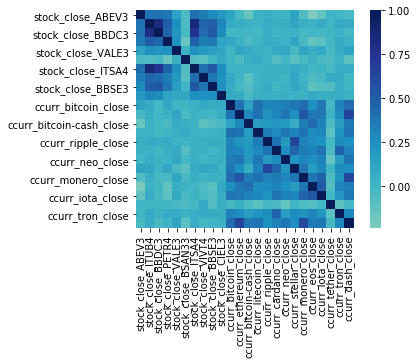

In [21]:
## Pearson correlation - All portafolio
sns.heatmap(percent_returns_pd.tail(360).corr(method='pearson'),  cmap="YlGnBu", center=0, square=True)

The behaviour described in the hypthotesis above, is showed in the data as well, menaning it works also for Brazilian stock assets.

### Drawing Markowitz efficient frontier


Different from other proposals, this method will take advantage of the already simulated portafolios, trying to reach for the maximum return at each fixed risk value.

For this, it is supposed that the portfolio with the maximum return and te portafolio with the minimal risk belong to the Markowitz efficient frontier, furthermore these ones may allow us to determine the interval of risk values within the quoted frontier. 

### OBS:

When simulating with genetic algorithims, there is a possibility of some portafolios may not match pre-fixed risk value. Furthemore there is a chance than a portafolio with a very close risk of any of the pre-fixed ones, may have a higher return value.

In order to minimize the effect of such issues, the efficient Markowithz frontier is going to be composed by the portafolios with the maximum return within an interval of +- 0.1 per each risk pre-fixed risk point. 

In [22]:
def return_risk_interval(df, number_of_steps = 5): 
    max_return = df.loc[df['return'] == max(df['return'])]
    min_risk = df.loc[df['risk'] == min(df['risk'])]

    delta = (max_return.iloc[0]['risk'] - min_risk.iloc[0]['risk']) / float(number_of_steps)
    if delta == 0:
        delta = 0.00001
    steps = list()

    for i in list(range(0,number_of_steps + 1)):
        if i == 0:
            steps.append(min_risk.iloc[0]['risk'])
        else:
            steps.append(steps[i-1] + delta)

    return [tuple([i-(delta*0.45), i+(delta*0.45)]) for i in steps] # 0,45 * delta guaranties interval overlapping does not Occur  

def drawing_frontier(df):
    steps_risk_interval = return_risk_interval(df)
    frontier = pd.DataFrame()
    for interval in steps_risk_interval:
        sliced_df = df.loc[(df['risk'] > interval[0])&(df['risk'] < interval[1])]

        if len(sliced_df) == 0: # If this condition is True, means for such interval, does not exist a solution.
            continue
            
        max_return_in_interval = max(sliced_df['return'])
        optimal_interval_portafolio = df.loc[df['return'] == max_return_in_interval].iloc[[0]]
        frontier = pd.concat([frontier, optimal_interval_portafolio])
    
    return frontier

# Call to execute
#frontier = drawing_frontier(df_ga_stock_output)  
#sns.lmplot(x="risk", y="distribution_return", data=frontier, fit_reg=True)


### From the portfolios within Markowitz efficient frontier, Ratio Sharpe is the measure that will allow to pick the best one.

According to (EAFIT reference), the most known investement startegies are:

** The equal wiehgt strategy:** Is one of the most used strategy in portfolio diversification due its simplicity in implementation and understading. It simply weights every stock in a portfolio equally.

** Minimum variance strategy:** Based on Markoweitz portfolio optimizatoin model, from the optimizied portfolios set, the portafolio with the minimum value of variance is selected.

** Mean variance straegy:** Once the Markowitz efficient frontier is calculated, Ratio of Sharpe will lead to significant clues about what portfolio may be the best one when the investor does not have a clear idea about the level of risk he would tolerate.

As sawn since the beginning of this work, the model presented in this work includes the last two.

Once the Markowitz frotnier is drawn, an investor is capable to pick the risk he will tolerate considering the probable return the portfolio might offer. But in many cases, if not the most, evaluate in which level of risk is desired to operate could result difficult to do.

Therefore, the ratio of sharpe is introduced as an helpful criterion to overcome such difficulties.  

This metric considers a free-risk asset in order to involve cost of opportunity (similar to ROI value).



$$ Ratio \ of \ Sharpe = \frac{𝑟_𝑝 − 𝑟_𝑓}{\sigma} $$

$$ Where \ \sigma = \sqrt{Variance(𝑟_𝑝 − 𝑟_𝑓)} ; if \ 𝑟_𝑓 \ is \ risk-free, \ then: 𝜎 = 𝜎_𝑝 $$

Finally 

$$ Ratio \ of \ Sharpe = \frac{𝑟_𝑝 − 𝑟_𝑓}{\sigma_p} $$



Further work could be leverage towards testing a modified Ratio of Sharpe considering VaR instead of the portfolio variance. This remains out of the scope of this work due it was demostrated that using either the normal Ratio of Shape or the modified Ratio of Shape, does not represent any significant gain in deveolping markets such as the Colombian one where the volatility is higher. This scenario is different in already developed markets such as the american where using VaR instead of variance does delivers siginificant improvements, therefore testing how this modified version of such ratio works in the Brazilian market, is a future work.

For the sake of simplicity it is assumed that Brazilian market and Colombian market are more similar to each other in terms of volatility compared with the similarity between American and Brazilian market in the same context.


$$ Modified \ Ratio \ of \ Sharpe = \frac{𝑟_𝑝 − 𝑟_𝑓}{𝑉𝑎𝑅} $$


In [23]:
def get_free_risk_asset_return(annual_rate=0.4, investment_period_in_days=30):
    daily_rate = (1.0+annual_rate)**(1.0/360.0) - 1.0
    free_risk_asset_return = 1
    for i in range(0, investment_period_in_days):
        free_risk_asset_return = free_risk_asset_return + (free_risk_asset_return * daily_rate)
        
    return free_risk_asset_return - 1
    
    
# Ratio of sharpe
def get_ratio_of_sharpe(weights, input_df, free_risk_asset_return):
    
    returns_portafolio = input_df.mean().dot(weights)
    std_portafolio = input_df.cov().dot(weights).dot(weights) ** 0.5

    return (returns_portafolio - free_risk_asset_return) / std_portafolio

## Getting return value of an asset by using GARCH models



In [45]:
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs


def tsplot(y, lags=None, figsize=(10, 8), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        #mpl.rcParams['font.family'] = 'Ubuntu Mono'
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))
        
        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)
        sm.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')        
        scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)

        plt.tight_layout()
    return

from arch import arch_model

def fit_garch(TS, p_range = 2, o_range = 0, q_range = 2, dist = "StudentsT"):
    best_aic = None
    best_order = None
    best_model = None
    for p in range(p_range+1):
        for o in range(o_range+1):
            for q in range(q_range+1):
                try:
                    am = arch_model(TS, p=p, o=o, q=q, dist = 'StudentsT')
                    res = am.fit(update_freq=5, disp='off')
                    tmp_aic = res.aic

                    if best_aic is None:
                        best_aic = tmp_aic
                    if tmp_aic <= best_aic:
                        dict_temp = {
                            'best_aic' : tmp_aic,
                            'results' : res
                        }
                except:
                    continue
    return dict_temp

#d = fit_garch(percent_returns_pd['ccurr_bitcoin-cash_close'])


In [46]:
test_returned = percent_stocks_returns.apply(lambda col: fit_garch(col)['results'].forecast().mean.iloc[-1])

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message i

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. Th

In [570]:
test_returned

,stock_close_ABEV3,stock_close_ITUB4,stock_close_BBDC3,stock_close_PETR4,stock_close_VALE3,stock_close_BSAN33,stock_close_ITSA4,stock_close_VIVT4,stock_close_BBSE3,stock_close_CIEL3
h.1,0.00047,0.001254,0.000551,0.001704,0.002352,0.000366,-0.014611,0.000194,-0.0002,-0.000771


Considering expression: 

$$ R_t = {e^{r_t}} - 1 $$

In [592]:
test_returned.apply(lambda col: (np.exp(col) - 1)).iloc[-1]

stock_close_ABEV3     0.000470
stock_close_ITUB4     0.001255
stock_close_BBDC3     0.000551
stock_close_PETR4     0.001706
stock_close_VALE3     0.002355
stock_close_BSAN33    0.000366
stock_close_ITSA4    -0.014505
stock_close_VIVT4     0.000194
stock_close_BBSE3    -0.000200
stock_close_CIEL3    -0.000771
Name: h.1, dtype: float64

## Random simulations - Workflow Example

A random simulation sets random values to the weights according to a given ditribution, gaussian mainly.

In [2]:
# test
def get_train_test_data(pd_dataframe, train_data_size):
    df_size = len(pd_dataframe.index)
    return pd_dataframe[0:df_size*train_data_size], pd_dataframe[df_size*train_data_size, df_size]

# Objective function using means for calculating returns
def random_simulations(input_df, num_simulations = 100):
    simulations = []
    returns_mean = input_df.mean() # Optimizes the process by calculating this just once
    returns_cov = input_df.cov() # Optimizes the process by calculating this just once
    for i in range(num_simulations):
        num_assets = len(input_df.columns)
        w = np.random.uniform(0,1,num_assets)
        if sum(w) == 0:
            w = w+(1e-2)
        w = w / sum(w)
        returns_portafolio = returns_mean.dot(w)
        std_portafolio = returns_cov.dot(w).dot(w) ** 0.5
        simulation = {'index' : i, 
                      'return' : returns_portafolio, 
                      'risk' : std_portafolio, 
                      'weights' : w, 
                      'assets' : list(input_df.mean().index)}
        simulations.append(simulation)
    return simulations

# Objective function using GARCH for calculating returns
def random_simulations_using_garch(input_df, num_simulations = 100):
    simulations = []
    returns_predict = input_df.apply(lambda col: fit_garch(col)['results'].forecast().mean.iloc[-1]) # Optimizes the process by calculating this just once
    returns_predict = returns_predict.apply(lambda col: (np.exp(col) - 1)).iloc[-1]
    returns_cov = input_df.cov() # Optimizes the process by calculating this just once
    for i in range(num_simulations):
        num_assets = len(input_df.columns)
        w = np.random.uniform(0,1,num_assets)
        if sum(w) == 0:
            w = w+(1e-2)
        w = w / sum(w)
        returns_portafolio = returns_predict.dot(w)
        std_portafolio = returns_cov.dot(w).dot(w) ** 0.5
        simulation = {'index' : i, 
                      'return' : returns_portafolio, 
                      'risk' : std_portafolio, 
                      'weights' : w, 
                      'assets' : list(input_df.mean().index)}
        simulations.append(simulation)
    return simulations

# Simulate portfolios method
def simulate_portafolios(function, lag = 0, window_time = 60, n = 1000):
    # Stocks only portafolio
    tail = len(percent_stocks_returns.index)
    map_test = function(percent_stocks_returns[tail - (lag + window_time): tail - lag], n)
    print('stocks.. init: '+str(tail - lag - window_time) + ' end: '+str(tail - lag))
    simulations_stock_df = pd.DataFrame(map_test)
    simulations_stock_df['portafolio_type'] = ['stock_only' for i in simulations_stock_df.index]

    # Criptocurrencies only portafolio
    tail = len(percent_cripto_returns.index)
    map_test = function(percent_cripto_returns[tail - (lag + window_time): tail - lag], n)
    print('ccurr.. init: '+str(tail - lag - window_time) + ' end: '+str(tail - lag))
    simulations_ccur_df = pd.DataFrame(map_test)
    simulations_ccur_df['portafolio_type'] = ['ccurr_only' for i in simulations_ccur_df.index]

    # Total portafolio
    tail = len(percent_returns_pd.index)
    map_test = function(percent_returns_pd[tail - (lag + window_time): tail - lag], n)
    print('mixed.. init: '+str(tail - lag - window_time) + ' end: '+str(tail - lag))
    simulations_df = pd.DataFrame(map_test)
    simulations_df['portafolio_type'] = ['mixed_assets' for i in simulations_df.index]
    
    return simulations_stock_df, simulations_ccur_df, simulations_df


stocks.. init: 310 end: 340
ccurr.. init: 506 end: 536
mixed.. init: 310 end: 340


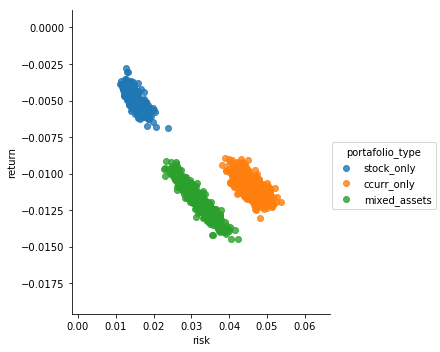

In [595]:
# Simulating Portfolios 
lag, window_time = 0, 30

# With mean
simulations_stock_df, simulations_ccur_df, simulations_df = simulate_portafolios(random_simulations, lag, window_time,500)

# With Garch
#simulations_stock_df, simulations_ccur_df, simulations_df = simulate_portafolios_with_garch(random_simulations_using_garch, lag, window_time,500)

simulation_frames = [simulations_stock_df, simulations_ccur_df, simulations_df]
simulations_concatenated = pd.concat(simulation_frames)

sns.lmplot(x="risk", y="return", hue="portafolio_type", data=simulations_concatenated, fit_reg=False)

*** Drawing Markowitz efficient frontier ***

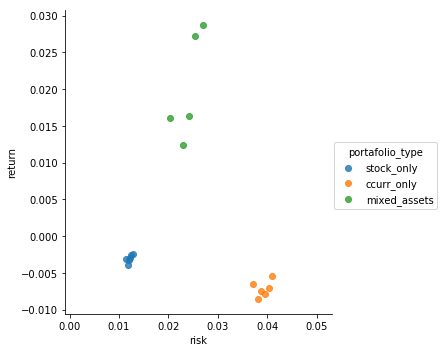

In [598]:
stock_frontier = drawing_frontier(simulations_stock_df)
ccur_frontier = drawing_frontier(simulations_ccur_df)
mixed_frontier = drawing_frontier(simulations_df)

summarized_frontiers = [stock_frontier, ccur_frontier, mixed_frontier]
summarized_frontiers = pd.concat(summarized_frontiers)

sns.lmplot(x="risk", y="return",hue="portafolio_type", data=summarized_frontiers, fit_reg=False)

In [54]:
stock_frontier

,assets,index,return,risk,weights,portafolio_type
66,"[stock_close_ABEV3, stock_close_ITUB4, stock_c...",66,-0.287916,1.161559,"[0.120009057151, 0.0653235547082, 0.0047292680...",stock_only
342,"[stock_close_ABEV3, stock_close_ITUB4, stock_c...",342,-0.283355,1.189348,"[0.133253148924, 0.0206694027458, 0.0032065729...",stock_only
222,"[stock_close_ABEV3, stock_close_ITUB4, stock_c...",222,-0.298772,1.235227,"[0.0516724168611, 0.0877427136813, 0.058061522...",stock_only
328,"[stock_close_ABEV3, stock_close_ITUB4, stock_c...",328,-0.359902,1.248992,"[0.0960433150568, 0.158727117303, 0.0222823470...",stock_only
219,"[stock_close_ABEV3, stock_close_ITUB4, stock_c...",219,-0.309452,1.302262,"[0.0177828858409, 0.125924491767, 0.1122914211...",stock_only
106,"[stock_close_ABEV3, stock_close_ITUB4, stock_c...",106,-0.253384,1.320788,"[0.0265433771001, 0.19211120673, 0.01125212387...",stock_only


*** Ratio of Sharpe ***

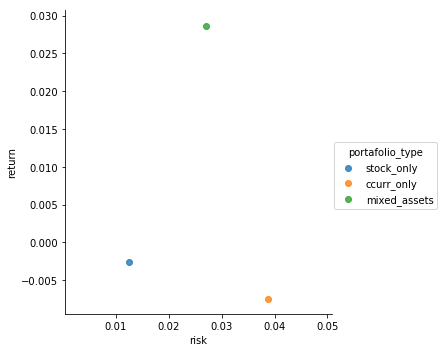

In [600]:
free_risk_asset = get_free_risk_asset_return(0.4, window_time)

# Calcuating ratio of sharpe of each asset belonging to the markwitz frontier

stock_frontier['ratio_of_sharpe'] = stock_frontier.apply(lambda x: get_ratio_of_sharpe(x['weights'], percent_stocks_returns, free_risk_asset) , axis = 1)
ccur_frontier['ratio_of_sharpe'] = ccur_frontier.apply(lambda x: get_ratio_of_sharpe(x['weights'], percent_cripto_returns, free_risk_asset) , axis = 1)
mixed_frontier['ratio_of_sharpe'] = mixed_frontier.apply(lambda x: get_ratio_of_sharpe(x['weights'], percent_returns_pd, free_risk_asset) , axis = 1)


# Finding the max ratio of sharpe of the markowitz frontier assets
df_sharpe_stock = stock_frontier.loc[stock_frontier['ratio_of_sharpe'] == max(stock_frontier['ratio_of_sharpe'])]
df_sharpe_ccur = ccur_frontier.loc[ccur_frontier['ratio_of_sharpe'] == max(ccur_frontier['ratio_of_sharpe'])]
df_sharpe_mixed_frontier =  mixed_frontier.loc[mixed_frontier['ratio_of_sharpe'] == max(mixed_frontier['ratio_of_sharpe'])]

# Ploting
summarized_sharpe = [df_sharpe_stock, df_sharpe_ccur, df_sharpe_mixed_frontier]
summarized_sharpe = pd.concat(summarized_sharpe)

sns.lmplot(x="risk", y="return",hue="portafolio_type", data=summarized_sharpe, fit_reg=False)

# Optimization with Genetic Algorithms

***OBS: *** Few data with a linear Opt. Function (substraction) tend to fall in local "maximus" (higher probabiity of exploit). Whereas a non-linear F.O. apparently does not.

### GA functions declaration

In [607]:
'''
@article{DEAP_JMLR2012, 
    author    = " F\'elix-Antoine Fortin and Fran\c{c}ois-Michel {De Rainville} and Marc-Andr\'e Gardner and Marc Parizeau and Christian Gagn\'e ",
    title     = { {DEAP}: Evolutionary Algorithms Made Easy },
    pages    = { 2171--2175 },
    volume    = { 13 },
    month     = { jul },
    year      = { 2012 },
    journal   = { Journal of Machine Learning Research }
'''

############### GA Implementation #############

def run_ga(percent_returns_pd, objective_function, use_garch = False):
    from deap import creator, base, tools, algorithms

    # Setting input portafolio dataframe 
    input_df = percent_returns_pd
    
    #Selecting which method should be used for calculating the returns by asset 
    if use_garch is False:
        returns = input_df.mean()
        input_returns_covariance = input_df.cov()
    else:
        returns = input_df.apply(lambda col: fit_garch(col)['results'].forecast().mean.iloc[-1])
        returns = returns.apply(lambda col: (np.exp(col) - 1)).iloc[-1]
        returns_cov = input_df.cov()
    
    # Objective function
    def objective_function_mean_returns(individual):
        if sum(individual) == 0:
            total = 1e-2
        else:
            total = sum(individual)
        w = np.divide(individual, total)
        return_portafolio = returns.dot(w)
        std_portafolio = input_returns_covariance.cov().dot(w).dot(w) ** 0.5
        return (return_portafolio / std_portafolio,) 
    
    creator.create("FitnessMax", base.Fitness, weights=(1.0,))
    creator.create("Individual", list, fitness=creator.FitnessMax)

    num_assets = len(input_df.columns)
    toolbox = base.Toolbox()
    toolbox.register("attr_flt", random.uniform, 0.001, 0.999)
    toolbox.register("individual", tools.initRepeat, creator.Individual,
                         toolbox.attr_flt, n=num_assets)
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)
    toolbox.register("evaluate", objective_function)
    toolbox.register("mate", tools.cxTwoPoint)
    toolbox.register("mutate", tools.mutFlipBit, indpb=0.3)
    toolbox.register("select", tools.selTournament, tournsize=3)

    population = toolbox.population(n=1000)
    hof = tools.HallOfFame(1)
    
    # Run GA
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", np.mean)
    stats.register("std", np.std)
    stats.register("min", np.min)
    stats.register("max", np.max)

    pop, log = algorithms.eaSimple(population, toolbox, cxpb=0.5, mutpb=0.2, ngen=40, 
                                       stats=stats, halloffame=hof, verbose=True)
    
    top10 = tools.selBest(population, k=10)
    return top10,pop, log, stats


############ Outputs processing ##############

def get_portafolio_stats(df_input, resource_optimal_distr):    
    average_close_portafolio = df_input.mean()
    cov_portafolio = df_input.cov()
    optimal_distr = resource_optimal_distr
    optimal_percentuals = np.divide(optimal_distr, sum(optimal_distr))
    return_in_percent = average_close_portafolio.dot(optimal_percentuals)
    risk_in_percent = cov_portafolio.dot(optimal_percentuals).dot(optimal_percentuals) ** 0.5
    return return_in_percent, risk_in_percent, resource_optimal_distr


## GA optimization - Workflow Example

***OBS:*** Experiments regarding the optimal number of assets are out of the scope of this work. Such number is defined by the premises adopted since the beginning. 
Considering the most signifcant companies/criptocurrencies according of its size. Companies with a minimum of 80% percent of summarized market capital.


In [3]:
def execute_by_interval(lag = 0, window_time = 60, is_garch = False):    
    # Stock only
    tail = len(percent_stocks_returns.index)
    top10_stock, pop_stock, log_stock, stas_stock = run_ga(percent_stocks_returns[tail - (lag + window_time): tail - lag],
                                                          is_garch)
    stats = []
    for individual in pop_stock:
        pop = np.divide(individual, sum(individual))
        stats.append(get_portafolio_stats(percent_stocks_returns[tail - (lag + window_time): tail - lag], pop))
    df_ga_stock_output = pd.DataFrame.from_records(stats) 
    df_ga_stock_output.columns = ['return', 'risk', 'weights']
    df_ga_stock_output['portafolio_type'] = ['stock_only' for i in df_ga_stock_output.index]

    # Cripto Currencies only
    tail = len(percent_cripto_returns.index)
    top10_ccurr, pop_ccurr, log_ccurr, stas_ccurr = run_ga(percent_cripto_returns[tail - (lag + window_time): tail - lag],
                                                          is_garch)
    stats = []
    for individual in pop_ccurr:
        pop = np.divide(individual, sum(individual))
        stats.append(get_portafolio_stats(percent_cripto_returns[tail - (lag + window_time): tail - lag], pop))
    df_ga_ccur_output = pd.DataFrame.from_records(stats) 
    df_ga_ccur_output.columns = ['return', 'risk', 'weights']
    df_ga_ccur_output['portafolio_type'] = ['ccurr_only' for i in df_ga_ccur_output.index]
    
    # Mixed Portafolio
    tail = len(percent_returns_pd.index)
    top10, pop, log, stas = run_ga(percent_returns_pd[tail - (lag + window_time): tail - lag],
                                  is_garch)
    stats = []
    for individual in pop:
        pop = np.divide(individual, sum(individual))
        stats.append(get_portafolio_stats(percent_returns_pd[tail - (lag + window_time): tail - lag], pop))
    df_ga_output = pd.DataFrame.from_records(stats) 
    df_ga_output.columns = ['return', 'risk', 'weights']
    df_ga_output['portafolio_type'] = ['mixed_assets' for i in df_ga_output.index]
    
    return df_ga_stock_output, df_ga_ccur_output, df_ga_output

In [ ]:
# Exectuing optimization using means with returns

# Using mean for returns    
#df_ga_stock_output, df_ga_ccur_output, df_ga_output = execute_by_interval(30,30, False)

# Using Garch for returns
df_ga_stock_output, df_ga_ccur_output, df_ga_output = execute_by_interval_using_garch(30,30, True)

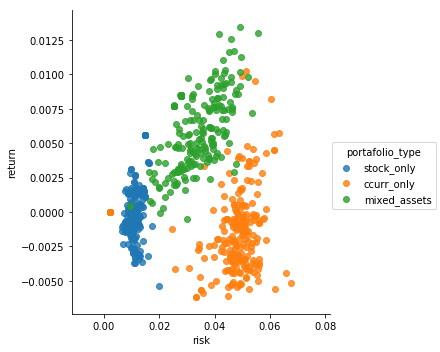

In [610]:
simulation_ga_frames = [df_ga_stock_output, df_ga_ccur_output, df_ga_output]
simulations_ga_concatenated = pd.concat(simulation_ga_frames)

sns.lmplot(x="risk", y="return", hue="portafolio_type", data=simulations_ga_concatenated, fit_reg=False)

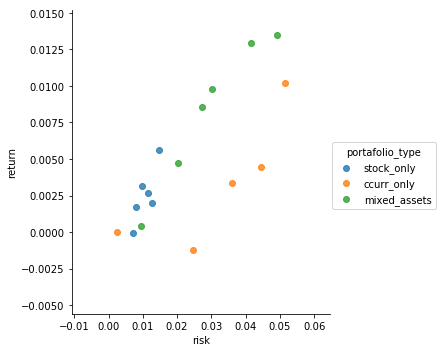

In [611]:
ga_stock_frontier = drawing_frontier(df_ga_stock_output)
ga_ccur_frontier = drawing_frontier(df_ga_ccur_output)
ga_mixed_frontier = drawing_frontier(df_ga_output)

# Required for ratio of sharpe
fixes_annual_return_rate = 0.4
pre_fixed_time_window = 5
ga_free_risk_asset = get_free_risk_asset_return(fixes_annual_return_rate, pre_fixed_time_window)

ga_stock_frontier['ratio_of_sharpe'] = ga_stock_frontier.apply(lambda x: get_ratio_of_sharpe(x['weights'], percent_stocks_returns, ga_free_risk_asset) , axis = 1)
ga_ccur_frontier['ratio_of_sharpe'] = ga_ccur_frontier.apply(lambda x: get_ratio_of_sharpe(x['weights'], percent_cripto_returns, ga_free_risk_asset) , axis = 1)
ga_mixed_frontier['ratio_of_sharpe'] = ga_mixed_frontier.apply(lambda x: get_ratio_of_sharpe(x['weights'], percent_returns_pd, ga_free_risk_asset) , axis = 1)

ga_summarized_frontiers = [ga_stock_frontier, ga_ccur_frontier, ga_mixed_frontier]
ga_summarized_frontiers = pd.concat(ga_summarized_frontiers)

sns.lmplot(x="risk", y="return",hue="portafolio_type", data=ga_summarized_frontiers, fit_reg=False)

### GA optimization vs Random Simulations

* Looking at the outcome plots of GA and Random simulation respectevaly, the main difference between these both is that GA allows a higher degree of the hyperspace exploration (Hyperspace is defined as the space where the possible silution are located), hence in GA the degree of exploting is lower, which enhaces the searching for global maximums.

* This might not be the case, but for portfolios composed by a signifacnlty higher number of assets, a random simulation dynamic is not suitable due this is considered a NP problem (not polynomial complexity problem in execution time).

## Optimizations(t) 

Once the optmization model is explained, the goal goes towards evaluate the protfolios behaviour in time.


** GA displacing time_window: ** It seeks to evaluate temporal behaviour considering a prefixed time_window displacing lags

In [627]:
tempos = dict()
num_iterations = 8
pre_fixed_time_window = 30
# Initialy we consider the lag per iteration with the same value of pre_fixed_time_window
lag_step_size = 0

# Required for ratio of sharpe
fixes_annual_return_rate = 0.4
ga_free_risk_asset = get_free_risk_asset_return(fixes_annual_return_rate, pre_fixed_time_window)

for i in range(0,num_iterations):
    print((num_iterations-i)*pre_fixed_time_window, pre_fixed_time_window)
    df_ga_stock_output, df_ga_ccur_output, df_ga_output = execute_by_interval_using_garch((num_iterations-i)*pre_fixed_time_window, pre_fixed_time_window)
    ga_stock_frontier,ga_ccur_frontier,ga_mixed_frontier = drawing_frontier(df_ga_stock_output), drawing_frontier(df_ga_ccur_output), drawing_frontier(df_ga_output)
   
    ga_stock_frontier['ratio_of_sharpe'] = ga_stock_frontier.apply(lambda x: get_ratio_of_sharpe(x['weights'], percent_stocks_returns, ga_free_risk_asset) , axis = 1)
    ga_ccur_frontier['ratio_of_sharpe'] = ga_ccur_frontier.apply(lambda x: get_ratio_of_sharpe(x['weights'], percent_cripto_returns, ga_free_risk_asset) , axis = 1)
    ga_mixed_frontier['ratio_of_sharpe'] = ga_mixed_frontier.apply(lambda x: get_ratio_of_sharpe(x['weights'], percent_returns_pd, ga_free_risk_asset) , axis = 1)

    tempos[(num_iterations-i)*pre_fixed_time_window] = dict()
    tempos[(num_iterations-i)*pre_fixed_time_window]['stock_frontier'] = ga_stock_frontier
    tempos[(num_iterations-i)*pre_fixed_time_window]['ccur_frontier'] = ga_ccur_frontier
    tempos[(num_iterations-i)*pre_fixed_time_window]['mixed_frontier'] = ga_mixed_frontier

150 30


/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. Th

gen	nevals	avg       	std      	min      	max       
0  	1000  	-0.0842907	0.0344566	-0.184924	0.00610028
1  	634   	-0.0567217	0.0326347	-0.207033	0.0490097 
2  	571   	-0.0343176	0.0322215	-0.192357	0.0577945 
3  	606   	-0.016723 	0.0359166	-0.212431	0.0586974 
4  	575   	-0.00154737	0.0357455	-0.212864	0.0589075 
5  	629   	nan        	nan      	nan      	nan       


/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:85: RuntimeWarning: invalid value encountered in double_scalars


6  	578   	0.0224305  	0.037104 	-0.180776	0.0644505 
7  	593   	0.031013   	0.0398313	-0.202905	0.0647433 
8  	639   	0.0348214  	0.0424111	-0.235146	0.0648873 
9  	599   	0.0374039  	0.0467096	-0.234992	0.0648873 
10 	602   	nan        	nan      	nan      	nan       
11 	609   	nan        	nan      	nan      	nan       
12 	580   	nan        	nan      	nan      	nan       
13 	595   	nan        	nan      	nan      	nan       
14 	587   	nan        	nan      	nan      	nan       
15 	615   	nan        	nan      	nan      	nan       
16 	645   	nan        	nan      	nan      	nan       
17 	603   	nan        	nan      	nan      	nan       
18 	597   	nan        	nan      	nan      	nan       
19 	605   	nan        	nan      	nan      	nan       
20 	603   	nan        	nan      	nan      	nan       
21 	589   	nan        	nan      	nan      	nan       
22 	627   	nan        	nan      	nan      	nan       
23 	625   	nan        	nan      	nan      	nan       
24 	604   	nan        	nan  

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in true_divide
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg      	std      	min       	max     
0  	1000  	0.0320428	0.0237862	-0.0447103	0.107842
1  	621   	0.0514318	0.0249684	-0.0514856	0.152222
2  	598   	0.0686611	0.0273039	-0.0454644	0.18617 
3  	592   	0.0885931	0.0304318	-0.0647531	0.210028
4  	605   	0.107005 	0.039881 	-0.122717 	0.267874
5  	577   	0.125157 	0.045537 	-0.0635251	0.299368
6  	603   	0.144093 	0.0507888	-0.12172  	0.267608
7  	606   	0.163324 	0.055007 	-0.0646681	0.303398
8  	585   	0.180299 	0.0616982	-0.132574 	0.327728
9  	606   	0.196923 	0.0716172	-0.0996222	0.327728
10 	562   	0.218365 	0.07621  	-0.139904 	0.333156
11 	585   	0.232942 	0.0845929	-0.0797838	0.336116
12 	620   	0.24409  	0.0941077	-0.131153 	0.336097
13 	589   	0.256126 	0.0972198	-0.135753 	0.336137
14 	577   	0.261834 	0.10737  	-0.141871 	0.336137
15 	566   	0.264891 	0.115139 	-0.145518 	0.336137
16 	585   	0.278666 	0.109203 	-0.137004 	0.336137
17 	575   	0.277872 	0.113493 	-0.138283 	0.336137
18 	587   	0.281398 	0.115386 	

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:85: RuntimeWarning: invalid value encountered in double_scalars


21 	647   	0.278218 	0.115217 	-0.116152 	0.336137
22 	623   	0.281757 	0.113301 	-0.128793 	0.336137
23 	611   	nan      	nan      	nan       	nan     
24 	611   	0.275955 	0.118759 	-0.145518 	0.336137
25 	570   	0.274128 	0.12113  	-0.138182 	0.336137
26 	642   	0.277329 	0.117607 	-0.144623 	0.336137
27 	607   	0.267638 	0.124988 	-0.145194 	0.336137
28 	600   	0.273369 	0.119441 	-0.11623  	0.336137
29 	589   	0.281366 	0.114763 	-0.135624 	0.336137
30 	630   	nan      	nan      	nan       	nan     
31 	605   	nan      	nan      	nan       	nan     
32 	605   	0.27324  	0.121102 	-0.145194 	0.336137
33 	624   	0.276421 	0.11849  	-0.11623  	0.336137
34 	604   	0.280783 	0.116403 	-0.145518 	0.336137
35 	562   	0.278068 	0.116517 	-0.116152 	0.336137
36 	605   	0.279886 	0.114406 	-0.135624 	0.336137
37 	591   	0.282801 	0.113281 	-0.12912  	0.336137
38 	665   	0.274849 	0.119421 	-0.11623  	0.336137
39 	569   	0.279534 	0.116755 	-0.145518 	0.336137
40 	591   	0.282654 	0.112545 	

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. Th

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg    	std    	min     	max    
0  	1000  	2.29982	1.42514	0.053839	7.85942
1  	605   	3.55549	1.80909	-0.0648638	18.0474
2  	613   	4.80093	2.30263	-0.0506906	20.1315
3  	640   	6.28828	2.791  	-0.0652879	29.2859
4  	579   	7.88288	3.14551	-0.0632044	20.2628
5  	620   	9.46792	4.33045	-0.0541216	50.0561
6  	609   	11.487 	5.32333	-0.0770897	50.0561
7  	596   	13.9128	6.95659	-0.0797848	70.2562
8  	602   	17.0714	8.57711	-0.118488 	70.2562
9  	573   	20.7872	9.58211	-0.0875086	70.2562
10 	624   	23.8797	11.294 	-0.0999676	59.9132
11 	601   	26.639 	13.824 	-0.0924586	70.6866
12 	568   	30.8484	15.7907	-0.11812  	78.0577
13 	605   	35.0117	19.1889	-0.186621 	139.247
14 	577   	42.7595	21.985 	-0.146851 	139.247
15 	605   	48.8212	25.7568	-0.154622 	139.247
16 	631   	55.7598	29.9026	-0.137381 	139.247
17 	598   	64.1399	34.5801	-0.0877069	194.132
18 	583   	74.1324	40.274 	-0.119577 	204.872
19 	625   	84.8101	46.1198	-0.104917 	305.535
20 	567   	97.432 	51.9045	-0.135636 	

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. Th

gen	nevals	avg     	std      	min     	max    
0  	1000  	0.231457	0.0555535	0.111846	0.41853
1  	591   	0.276091	0.0613765	0.0867144	0.5123 
2  	590   	0.316678	0.0623275	0.0731256	0.52296
3  	583   	0.349004	0.0709057	0.0878736	0.52296
4  	617   	0.381868	0.0762786	0.050921 	0.525885
5  	613   	0.414158	0.0776584	0.070236 	0.536675
6  	630   	0.433766	0.0902166	0.0361138	0.536675
7  	576   	0.450923	0.101486 	0.0316274	0.540749
8  	605   	nan     	nan      	nan      	nan     


/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:85: RuntimeWarning: invalid value encountered in double_scalars


9  	622   	nan     	nan      	nan      	nan     
10 	588   	0.477908	0.114393 	0.0361138	0.542473
11 	577   	nan     	nan      	nan      	nan     
12 	573   	nan     	nan      	nan      	nan     
13 	611   	nan     	nan      	nan      	nan     
14 	585   	nan     	nan      	nan      	nan     
15 	595   	nan     	nan      	nan      	nan     
16 	581   	nan     	nan      	nan      	nan     
17 	625   	nan     	nan      	nan      	nan     
18 	600   	nan     	nan      	nan      	nan     
19 	631   	0.485244	0.125351 	0.0433643	0.543175
20 	581   	0.49146 	0.118997 	0.0415147	0.543175
21 	603   	nan     	nan      	nan      	nan     
22 	619   	0.496093	0.113403 	0.0361138	0.543175
23 	630   	nan     	nan      	nan      	nan     
24 	574   	nan     	nan      	nan      	nan     
25 	589   	nan     	nan      	nan      	nan     
26 	613   	nan     	nan      	nan      	nan     
27 	622   	nan     	nan      	nan      	nan     
28 	597   	0.492166	0.117207 	0.0550137	0.543175
29 	615   	nan     	

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in true_divide
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg       	std      	min      	max       
0  	1000  	-0.0801056	0.0157682	-0.137216	-0.0304313
1  	607   	-0.0666895	0.0145593	-0.119666	-0.00214166
2  	622   	-0.0554247	0.0154404	-0.131014	0.00669123 
3  	598   	-0.0449679	0.0187627	-0.140941	0.0306595  
4  	603   	-0.034521 	0.0201084	-0.142321	0.0306595  
5  	580   	-0.0240439	0.0231823	-0.152552	0.0336877  
6  	603   	-0.0167675	0.0268622	-0.169797	0.0492356  
7  	594   	-0.00897494	0.0279924	-0.156159	0.0492356  
8  	593   	-0.00132419	0.0335067	-0.185813	0.0492356  
9  	608   	0.00660632 	0.0349442	-0.15172 	0.0530873  
10 	618   	0.0115501  	0.0392679	-0.219378	0.0530873  
11 	585   	0.017502   	0.0415899	-0.156856	0.0530873  
12 	612   	0.0220889  	0.0440202	-0.175056	0.0530982  
13 	616   	0.0265272  	0.0456836	-0.222592	0.0531342  
14 	582   	0.027684   	0.047018 	-0.221425	0.0531338  
15 	616   	0.0303715  	0.0468989	-0.221425	0.0531362  
16 	582   	nan        	nan      	nan      	nan        


/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:85: RuntimeWarning: invalid value encountered in double_scalars


17 	611   	nan        	nan      	nan      	nan        
18 	612   	nan        	nan      	nan      	nan        
19 	605   	nan        	nan      	nan      	nan        
20 	595   	nan        	nan      	nan      	nan        
21 	593   	nan        	nan      	nan      	nan        
22 	591   	nan        	nan      	nan      	nan        
23 	590   	0.030047   	0.04935  	-0.168471	0.0531362  
24 	595   	nan        	nan      	nan      	nan        
25 	569   	nan        	nan      	nan      	nan        
26 	578   	nan        	nan      	nan      	nan        
27 	584   	0.0301399  	0.0507322	-0.200287	0.0531362  
28 	583   	0.0305327  	0.0479387	-0.221425	0.0531362  
29 	606   	0.0284359  	0.0510418	-0.169374	0.0531362  
30 	617   	0.0308791  	0.0484235	-0.197551	0.0531362  
31 	621   	0.0293325  	0.050091 	-0.213052	0.0531362  
32 	609   	0.0279854  	0.0522385	-0.213052	0.0531362  
33 	584   	0.028127   	0.0529347	-0.213052	0.0531362  
34 	591   	0.0295098  	0.0502629	-0.213052	0.0531362  
35 	585   

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:56: RuntimeWarning: invalid value encountered in true_divide
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


gen	nevals	avg     	std      	min     	max     
0  	1000  	0.287424	0.0384869	0.163486	0.419489
1  	586   	0.317665	0.0374384	0.178861	0.472527
2  	577   	0.343069	0.0400127	0.136293	0.508019
3  	585   	0.368418	0.0446569	0.152319	0.575724
4  	601   	0.391784	0.0510508	0.122138	0.575724
5  	616   	0.415105	0.0549223	0.183666	0.575724
6  	642   	0.429469	0.06906  	0.0958648	0.578392
7  	605   	0.448006	0.0755821	0.122596 	0.583463
8  	599   	0.465786	0.0864486	0.0882567	0.587911
9  	590   	0.48069 	0.0957265	0.088725 	0.596272
10 	648   	0.493756	0.0999316	0.114391 	0.608277
11 	639   	0.508613	0.105642 	0.0453522	0.609814
12 	591   	0.515509	0.112397 	0.132227 	0.609814
13 	583   	0.521066	0.118598 	0.123587 	0.609855
14 	616   	0.530544	0.113136 	0.0987585	0.614547
15 	608   	0.531472	0.119431 	0.0684828	0.630912
16 	617   	0.534876	0.12067  	0.0640621	0.633692
17 	540   	0.550381	0.115791 	0.0536562	0.634191
18 	571   	0.549512	0.124236 	0.0737677	0.636164
19 	600   	0.552922	0.12680

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. Th

gen	nevals	avg     	std      	min     	max     
0  	1000  	0.326521	0.0333712	0.233125	0.433384
1  	595   	0.350175	0.0390837	0.0728843	0.496668
2  	627   	0.373489	0.0375811	0.126695 	0.523823
3  	620   	0.394057	0.0401222	0.171464 	0.523823
4  	593   	0.415115	0.0456958	0.132368 	0.523823
5  	571   	0.433469	0.0574723	0.0319175	0.540564
6  	603   	0.447372	0.0707514	0.0438062	0.55074 
7  	620   	0.466269	0.070913 	0.0491936	0.571974
8  	594   	nan     	nan      	nan      	nan     
9  	598   	0.494071	0.08756  	0.0485192	0.573951

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:85: RuntimeWarning: invalid value encountered in double_scalars



10 	603   	nan     	nan      	nan      	nan     
11 	593   	nan     	nan      	nan      	nan     
12 	583   	nan     	nan      	nan      	nan     
13 	582   	nan     	nan      	nan      	nan     
14 	642   	nan     	nan      	nan      	nan     
15 	602   	nan     	nan      	nan      	nan     
16 	579   	nan     	nan      	nan      	nan     
17 	607   	nan     	nan      	nan      	nan     
18 	597   	nan     	nan      	nan      	nan     
19 	582   	nan     	nan      	nan      	nan     
20 	598   	nan     	nan      	nan      	nan     
21 	610   	nan     	nan      	nan      	nan     
22 	600   	nan     	nan      	nan      	nan     
23 	605   	nan     	nan      	nan      	nan     
24 	596   	nan     	nan      	nan      	nan     
25 	579   	nan     	nan      	nan      	nan     
26 	591   	nan     	nan      	nan      	nan     
27 	606   	nan     	nan      	nan      	nan     
28 	626   	nan     	nan      	nan      	nan     
29 	636   	nan     	nan      	nan      	nan     
30 	605   	nan     

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in true_divide
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)



gen	nevals	avg      	std      	min      	max      
0  	1000  	-0.331718	0.0227473	-0.407661	-0.250734
1  	612   	-0.311967	0.0231477	-0.421488	-0.208213
2  	614   	-0.293071	0.0239495	-0.379726	-0.177788
3  	604   	-0.275585	0.0254757	-0.398404	-0.184515
4  	623   	-0.259709	0.0301147	-0.394201	-0.190006
5  	602   	-0.245373	0.0327142	-0.430529	-0.163437
6  	580   	-0.231686	0.0354538	-0.395891	-0.1517  
7  	628   	-0.222756	0.0411979	-0.412667	-0.1517  
8  	579   	-0.211947	0.0453318	-0.455859	-0.143914
9  	585   	nan      	nan      	nan      	nan      

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:85: RuntimeWarning: invalid value encountered in double_scalars



10 	621   	-0.198483	0.0583526	-0.514117	-0.12263 
11 	586   	nan      	nan      	nan      	nan      
12 	615   	-0.181503	0.0622957	-0.481253	-0.12263 
13 	599   	nan      	nan      	nan      	nan      
14 	610   	nan      	nan      	nan      	nan      
15 	588   	nan      	nan      	nan      	nan      
16 	597   	-0.16292 	0.0797396	-0.500826	-0.0605279
17 	584   	nan      	nan      	nan      	nan       
18 	593   	nan      	nan      	nan      	nan       
19 	598   	nan      	nan      	nan      	nan       
20 	597   	nan      	nan      	nan      	nan       
21 	603   	nan      	nan      	nan      	nan       
22 	594   	nan      	nan      	nan      	nan       
23 	601   	nan      	nan      	nan      	nan       
24 	619   	nan      	nan      	nan      	nan       
25 	622   	nan      	nan      	nan      	nan       
26 	576   	nan      	nan      	nan      	nan       
27 	639   	nan      	nan      	nan      	nan       
28 	629   	nan      	nan      	nan      	nan       
29 	605   	nan   

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:56: RuntimeWarning: invalid value encountered in true_divide
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


gen	nevals	avg     	std     	min      	max       
0  	1000  	-0.13859	0.029024	-0.218681	-0.0310509
1  	639   	-0.114071	0.0291451	-0.246237	-0.0239748
2  	595   	-0.0909545	0.0309338	-0.227494	0.0500091 
3  	574   	-0.0675207	0.0326023	-0.218492	0.0761785 
4  	582   	-0.0468864	0.0394924	-0.23251 	0.171626  
5  	582   	-0.0277439	0.0502722	-0.271075	0.208987  
6  	625   	-0.00243729	0.0543589	-0.241847	0.260451  
7  	609   	0.0192413  	0.0639239	-0.252214	0.260451  
8  	597   	0.0382504  	0.0759562	-0.230743	0.30636   
9  	573   	0.0592699  	0.0925218	-0.273512	0.348687  
10 	590   	0.0844736  	0.105039 	-0.279661	0.37202   
11 	597   	0.111164   	0.116702 	-0.257435	0.366854  
12 	620   	0.144527   	0.133586 	-0.293617	0.423502  
13 	589   	0.178585   	0.147067 	-0.240346	0.423502  
14 	578   	0.214277   	0.157791 	-0.260301	0.513699  
15 	613   	0.246731   	0.169553 	-0.271244	0.513699  
16 	597   	0.273911   	0.181241 	-0.288188	0.513699  
17 	590   	0.290771   	0.188376 	-0.264817

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:85: RuntimeWarning: invalid value encountered in double_scalars


36 	595   	nan        	nan      	nan      	nan       
37 	632   	0.431316   	0.279957 	-0.295577	0.574233  
38 	618   	0.415793   	0.288397 	-0.294538	0.574233  
39 	637   	0.406811   	0.296391 	-0.276084	0.574233  
40 	601   	nan        	nan      	nan      	nan       


/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:67: RuntimeWarning: invalid value encountered in true_divide


60 30


/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. Th

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. Th

gen	nevals	avg       	std      	min      	max   
0  	1000  	-0.0478681	0.0642135	-0.234202	0.1333
1  	605   	0.00575165	0.0560774	-0.309042	0.273481
2  	587   	0.0456842 	0.0559659	-0.317938	0.30284 
3  	579   	0.0800787 	0.0628639	-0.319121	0.30284 
4  	562   	0.111333  	0.070228 	-0.308297	0.296792
5  	612   	0.140619  	0.0748267	-0.356341	0.321918
6  	615   	0.162674  	0.0885878	-0.32585 	0.321918
7  	582   	0.187952  	0.0934368	-0.352991	0.324287
8  	600   	0.213854  	0.0948862	-0.305707	0.324706
9  	580   	0.226002  	0.108753 	-0.352991	0.324706
10 	597   	0.232677  	0.117179 	-0.30798 	0.324736
11 	611   	0.249669  	0.110326 	-0.271157	0.324706
12 	622   	0.250675  	0.126259 	-0.328722	0.324925
13 	572   	nan       	nan      	nan      	nan     


/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:85: RuntimeWarning: invalid value encountered in double_scalars


14 	627   	nan       	nan      	nan      	nan     
15 	591   	0.265476  	0.129889 	-0.306992	0.325148
16 	588   	nan       	nan      	nan      	nan     
17 	604   	0.259539  	0.140521 	-0.351902	0.325149
18 	567   	nan       	nan      	nan      	nan     
19 	651   	nan       	nan      	nan      	nan     
20 	565   	0.256175  	0.141956 	-0.348018	0.325159
21 	644   	0.267388  	0.12938  	-0.349645	0.325159
22 	601   	0.253489  	0.147846 	-0.349645	0.325159
23 	614   	0.26265   	0.136441 	-0.329729	0.325159
24 	599   	nan       	nan      	nan      	nan     
25 	596   	0.263817  	0.135955 	-0.347883	0.325159
26 	576   	0.271421  	0.123011 	-0.25164 	0.325159
27 	593   	0.263047  	0.136606 	-0.280167	0.325159
28 	585   	0.274022  	0.123611 	-0.319449	0.325159
29 	581   	nan       	nan      	nan      	nan     
30 	596   	nan       	nan      	nan      	nan     
31 	631   	nan       	nan      	nan      	nan     
32 	593   	0.264797  	0.134642 	-0.30496 	0.325159
33 	623   	0.262984  	0.135775 

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in true_divide
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


gen	nevals	avg     	std     	min      	max    
0  	1000  	0.701366	0.376955	0.0398693	1.79948
1  	589   	1.02451 	0.435598	0.0212554	2.94044
2  	622   	1.35092 	0.548726	0.0119398	4.64793
3  	574   	1.73232 	0.763819	0.0309351	12.2443
4  	600   	2.24589 	1.56327 	0.0134385	37.2961

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:85: RuntimeWarning: invalid value encountered in double_scalars



5  	601   	nan     	nan     	nan      	nan    
6  	619   	nan     	nan     	nan      	nan    
7  	588   	nan     	nan     	nan      	nan    
8  	577   	6.59706 	6.72648 	0.0013177	98.6378
9  	587   	9.2572  	10.7659 	-0.016625	99.1998
10 	614   	13.9979 	16.3737 	-0.0130407	100.909
11 	615   	20.7392 	21.7126 	-0.0351376	100.909
12 	629   	32.9144 	30.2094 	-0.0110264	100.909
13 	614   	46.9092 	35.3243 	0.00237917	100.909
14 	597   	62.6186 	38.2797 	-0.0162006	100.978
15 	636   	nan     	nan     	nan       	nan    
16 	591   	nan     	nan     	nan       	nan    
17 	619   	nan     	nan     	nan       	nan    
18 	616   	77.0092 	41.1038 	-0.0413022	101.003
19 	626   	nan     	nan     	nan       	nan    
20 	609   	nan     	nan     	nan       	nan    
21 	632   	81.1858 	39.2229 	-0.0413022	101.003
22 	626   	nan     	nan     	nan       	nan    
23 	581   	nan     	nan     	nan       	nan    
24 	608   	79.8118 	40.7221 	-0.00108855	101.003
25 	596   	80.4298 	40.2718 	-0.0413022 	10

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. Th

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 9. The message is:
Iteration limit exceeded
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive

gen	nevals	avg      	std      	min      	max       
0  	1000  	-0.142148	0.0296121	-0.228456	-0.0334757
1  	629   	-0.117027	0.0289549	-0.242004	-0.00485989
2  	609   	-0.0971535	0.0296257	-0.226101	0.0380039  
3  	596   	-0.0756905	0.0323255	-0.227893	0.0490577  
4  	633   	-0.0566258	0.0370034	-0.271124	0.11522    
5  	562   	-0.0365329	0.0421615	-0.266562	0.11522    
6  	635   	-0.0202012	0.0481398	-0.247994	0.130908   
7  	585   	0.000858256	0.0490839	-0.262373	0.130908   
8  	618   	0.0110766  	0.0616117	-0.298827	0.137912   
9  	600   	0.0308257  	0.0629589	-0.229983	0.141792   
10 	579   	0.0453958  	0.0687386	-0.246576	0.176291   
11 	565   	0.0630536  	0.0726316	-0.270004	0.166363   
12 	594   	0.0693639  	0.0857344	-0.306129	0.183181   
13 	569   	0.0919449  	0.0823668	-0.255007	0.183181   
14 	615   	0.0966098  	0.0888044	-0.269608	0.228482   
15 	594   	0.106688   	0.094125 	-0.262733	0.228482   
16 	595   	0.106129   	0.107769 	-0.277486	0.271885   
17 	581   	0.114434   	

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. Th

gen	nevals	avg       	std      	min      	max      
0  	1000  	-0.0639839	0.0521072	-0.250964	0.0790441
1  	595   	-0.0215662	0.0520653	-0.242438	0.246202 
2  	591   	0.0181555 	0.0582455	-0.234404	0.296207 
3  	590   	0.0549975 	0.0629905	-0.257213	0.28488  
4  	618   	0.0917188 	0.0704098	-0.254552	0.327406 
5  	594   	0.122894  	0.0851685	-0.307215	0.343142 
6  	607   	0.151388  	0.0913754	-0.253453	0.343282 
7  	615   	0.181749  	0.103242 	-0.321636	0.343282 
8  	609   	nan       	nan      	nan      	nan      
9  	606   	0.238731  	0.114526 	-0.239019	0.343282 

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:85: RuntimeWarning: invalid value encountered in double_scalars



10 	583   	nan       	nan      	nan      	nan      
11 	609   	nan       	nan      	nan      	nan      
12 	613   	nan       	nan      	nan      	nan      
13 	575   	nan       	nan      	nan      	nan      
14 	588   	nan       	nan      	nan      	nan      
15 	571   	nan       	nan      	nan      	nan      
16 	603   	nan       	nan      	nan      	nan      
17 	610   	nan       	nan      	nan      	nan      
18 	588   	nan       	nan      	nan      	nan      
19 	615   	nan       	nan      	nan      	nan      
20 	590   	nan       	nan      	nan      	nan      
21 	634   	nan       	nan      	nan      	nan      
22 	612   	nan       	nan      	nan      	nan      
23 	566   	nan       	nan      	nan      	nan      
24 	580   	0.282916  	0.138002 	-0.320956	0.343295 
25 	585   	nan       	nan      	nan      	nan      
26 	583   	nan       	nan      	nan      	nan      
27 	589   	nan       	nan      	nan      	nan      
28 	610   	nan       	nan      	nan      	nan      
29 	589   	

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in true_divide
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


gen	nevals	avg       	std      	min      	max       
0  	1000  	-0.0897031	0.0218917	-0.157787	-0.0133143
1  	595   	-0.0702263	0.0226611	-0.194033	0.0444439 
2  	585   	-0.0531728	0.0253713	-0.175493	0.0915029 
3  	625   	-0.0366214	0.0294854	-0.179869	0.0915029 
4  	623   	-0.0191583	0.032623 	-0.177349	0.0915029 
5  	611   	-0.00330882	0.0406742	-0.218015	0.127025  
6  	585   	0.014856   	0.0421285	-0.180148	0.131647  
7  	603   	0.0298981  	0.0469768	-0.189226	0.131647  
8  	591   	0.0440786  	0.0516699	-0.177939	0.144375  
9  	591   	0.0561534  	0.0603524	-0.180437	0.163333  
10 	592   	0.069236   	0.0656018	-0.192429	0.169784  
11 	607   	0.0768633  	0.0752213	-0.223182	0.169784  
12 	622   	0.0912169  	0.0788164	-0.206844	0.268685  
13 	625   	0.0983891  	0.0846345	-0.218882	0.268685  
14 	567   	0.109437   	0.0894307	-0.189985	0.662621  
15 	589   	0.118802   	0.0946215	-0.209479	0.662621  
16 	611   	0.118887   	0.102598 	-0.203908	0.662621  
17 	590   	0.125216   	0.107904 	-

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:85: RuntimeWarning: invalid value encountered in double_scalars


19 	582   	nan        	nan      	nan      	nan       
20 	616   	nan        	nan      	nan      	nan       
21 	589   	nan        	nan      	nan      	nan       
22 	633   	0.37329    	0.309524 	-0.231625	0.662621  
23 	634   	0.454207   	0.316731 	-0.224251	0.662621  
24 	598   	nan        	nan      	nan      	nan       
25 	605   	nan        	nan      	nan      	nan       
26 	627   	nan        	nan      	nan      	nan       
27 	601   	nan        	nan      	nan      	nan       
28 	606   	0.491672   	0.314611 	-0.206225	0.662621  
29 	608   	nan        	nan      	nan      	nan       
30 	610   	nan        	nan      	nan      	nan       
31 	615   	nan        	nan      	nan      	nan       
32 	626   	0.510047   	0.300095 	-0.219447	0.662621  
33 	598   	0.518075   	0.29509  	-0.207253	0.662621  
34 	600   	0.504584   	0.306095 	-0.258184	0.662621  
35 	589   	0.521011   	0.291879 	-0.224956	0.662621  
36 	608   	nan        	nan      	nan      	nan       
37 	598   	nan        	nan  

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:56: RuntimeWarning: invalid value encountered in true_divide
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


gen	nevals	avg     	std      	min      	max     
0  	1000  	0.164184	0.0246079	0.0883534	0.248325
1  	593   	0.184443	0.025581 	0.0417783	0.285288
2  	601   	0.201306	0.028619 	0.0527156	0.295966
3  	572   	0.220204	0.0286578	0.0621841	0.328037
4  	597   	0.234226	0.031754 	0.0676599	0.332115
5  	625   	0.247836	0.0363865	0.0501933	0.332115
6  	612   	0.263118	0.0366948	0.0987414	0.348811
7  	572   	0.276435	0.0402708	0.0411682	0.355332
8  	612   	0.283034	0.0483067	0.0534086	0.36371 
9  	602   	0.291703	0.0542404	0.0471139	0.388092
10 	603   	0.302954	0.0545005	-0.0262943	0.372856
11 	591   	0.308771	0.0583401	0.0296566 	0.372856
12 	592   	0.315966	0.0620939	0.0190361 	0.381804
13 	588   	0.319265	0.0669155	-0.0244811	0.38424 
14 	565   	0.321997	0.0723389	0.0196807 	0.38424 
15 	591   	0.328941	0.0715294	0.0491413 	0.387359
16 	600   	0.337564	0.0708948	-0.039108 	0.390657
17 	603   	0.339992	0.074967 	-0.0288606	0.394927
18 	586   	0.342305	0.0768892	-0.0369224	0.394927
19 	615   	

In [628]:
# Generating time series of best portfolios selected by ratio of sharpe

ccur_ts = dict()
stock_ts = dict()
mixed_ts = dict()
for k,v in tempos.items():
    ccur_ts[k] = v['ccur_frontier'].loc[v['ccur_frontier']['ratio_of_sharpe'] == max(v['ccur_frontier']['ratio_of_sharpe'])].values[0]
    ccur_columns = v['ccur_frontier'].columns
    stock_ts[k] = v['stock_frontier'].loc[v['stock_frontier']['ratio_of_sharpe'] == max(v['stock_frontier']['ratio_of_sharpe'])].values[0]
    stock_columns = v['stock_frontier'].columns
    mixed_ts[k] = v['mixed_frontier'].loc[v['mixed_frontier']['ratio_of_sharpe'] == max(v['mixed_frontier']['ratio_of_sharpe'])].values[0]
    mixed_columns = v['mixed_frontier'].columns
    
ccur_ts = pd.DataFrame.from_dict(ccur_ts, orient='index')
ccur_ts.columns = ccur_columns

stock_ts =  pd.DataFrame.from_dict(stock_ts, orient='index')
stock_ts.columns = stock_columns

mixed_ts = pd.DataFrame.from_dict(mixed_ts, orient='index')
mixed_ts.columns = mixed_columns

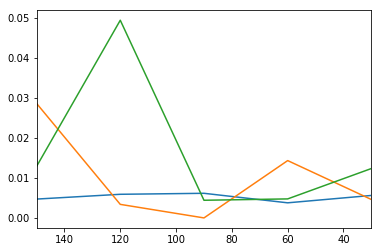

In [629]:
stock_ts['return'].plot()
stock_ts['risk'].plot()

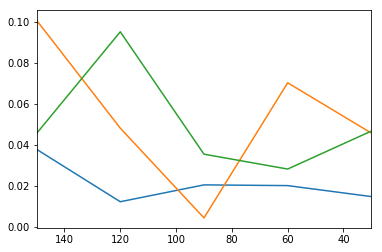

In [630]:
ccur_ts['return'].plot()
ccur_ts['risk'].plot()

In [ ]:
mixed_ts['return'].plot()
mixed_ts['risk'].plot()

In [631]:
# Calcular el VaR como medida interesante y mas fiable de los retornos
# Graficar el plot de las combinaciones de todos las combinaciones de las carteras

## Further outcome analysis

*** Temporal Aggregated Error and residual analysis ***



*** Mixed assets portfolio distribution of the outcome ***

Once the optimal portoflio has been calculated in each time period where the model ran, it is also desired to explore further whether the composition of mixed protfolios presents any pattern or not. This aims towards giving a basic insight about the optimal distribution of a portfolio of such type by knowing the percent of the capital destinated to stocks and to the criptocurrencies.   

In [632]:
num_stock_asset = len(percent_stocks_returns.columns)
num_cripto_assets = len(percent_cripto_returns.columns)

mixed_ts['percent_in_stocks'] = [100*sum(portfolio[0:num_stock_asset]) for portfolio in mixed_ts['weights']]
mixed_ts['percent_in_cripto'] = [100*sum(portfolio[num_stock_asset:num_stock_asset+num_cripto_assets]) for portfolio in mixed_ts['weights']]

mixed_ts['lag_in_days'] = mixed_ts.index

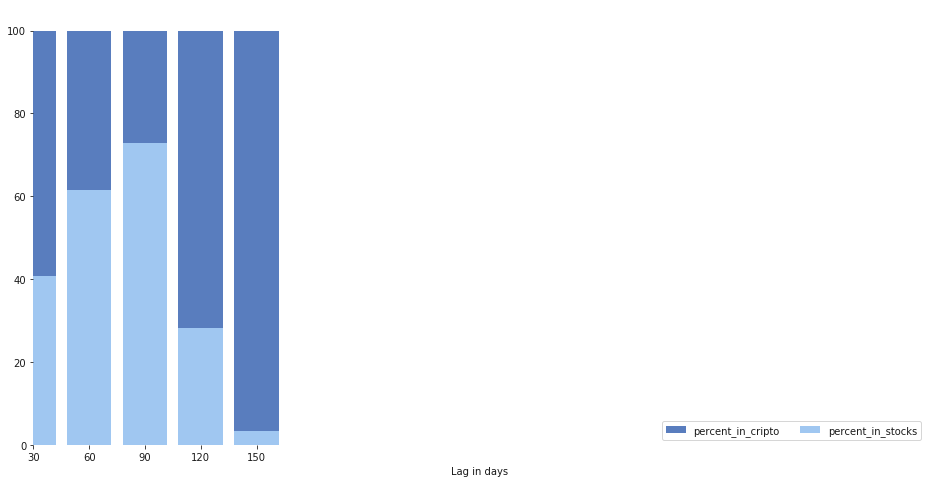

In [633]:
# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(16, 8))

mixed_ts['temp_dim'] = [100 for portfolio in mixed_ts['weights']]
# Plot the crashes where alcohol was involved
sns.set_color_codes("muted")
sns.barplot(x="lag_in_days", y="temp_dim", data=mixed_ts,
            label="percent_in_cripto", color="b")

# Plot the total crashes
sns.set_color_codes("pastel")
sns.barplot(x="lag_in_days", y="percent_in_stocks", data=mixed_ts,
            label="percent_in_stocks", color="b")


# Add a legend and informative axis label
ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set(xlim=(0, 16), ylabel="",
       xlabel="Lag in days")
sns.despine(left=True, bottom=True)

In [634]:
# Cleaning df
mixed_ts.drop(['temp_dim', 'lag_in_days'], axis = 1)

,return,risk,weights,portafolio_type,ratio_of_sharpe,percent_in_stocks,percent_in_cripto
150,0.012855,0.045616,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.032...",mixed_assets,-0.249399,3.230175,96.769825
120,0.049416,0.095202,"[0.0, 0.0, 0.109338355367, 0.0, 0.0, 0.1488134...",mixed_assets,-0.379809,28.252366,71.747634
90,0.004382,0.035520,"[0.135076513561, 0.135076513561, 0.0, 0.0, 0.0...",mixed_assets,-0.884798,72.984697,27.015303
60,0.004722,0.028266,"[0.335763435359, 0.0, 0.0, 0.280078517722, 0.0...",mixed_assets,-0.738469,61.584195,38.415805
30,0.012323,0.046801,"[0.204504213743, 0.0, 0.0, 0.0, 0.202093331283...",mixed_assets,-0.409423,40.659755,59.340245


# TO DO:

* Clean data, at least for criptocurrencies with few tracking history registers. [X]
* Fix when a big amount of past data is considered when performing optmizations [OK]
* Select most valuable assets of Bovespa [OK - But considering the state in Marxh Only]
* Demonstrate variation between cotations in real and dolar - Not relevant because a differianted series is taken.
* Calculate the mixed portfolios distribution in 3 stages:
    * Ratio of sharpe
    * Max. return
    * Min. Risk
    
* Real error analysis (Mean - retorno real) for normal AVG - and AVG
* GARCH models, calculate the return of a single asset, this will minimize the error.
* Calculate the real return after calculating all optimized portfolios within the defined time interval.